In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import time
import torch
from torch.autograd import Variable

import numpy as np
from sklearn import manifold, datasets
import scipy.sparse as sp
import pickle

if torch.cuda.is_available():
    print('cuda available')
    dtypeFloat = torch.cuda.FloatTensor
    dtypeLong = torch.cuda.LongTensor
    #torch.cuda.manual_seed(1)
else:
    print('cuda not available')
    dtypeFloat = torch.FloatTensor
    dtypeLong = torch.LongTensor
    #torch.manual_seed(1)
    
from core.DimReduction import DimReduction
from core.GraphConvNet2 import GraphConvNet2
from util.mnist_data_loader import get_train_set, get_test_set
from util.plot_embedding import plot_embedding

cuda not available


In [3]:
dim_reduction = DimReduction(n_components=2)

In [4]:
task_parameters = {}
task_parameters['flag_task'] = 'clustering'

net_parameters = {}
net_parameters['D'] = 784
net_parameters['n_components'] = 2
net_parameters['H'] = 50
net_parameters['L'] = 10

In [5]:
net = GraphConvNet2(net_parameters, task_parameters)
print(net)


nb of hidden layers= 10
dim of layers (w/ embed dim)= [784, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]


GraphConvNet2(
  (gnn_cells): ModuleList(
    (0): GraphConvNetcell(
      (Ui1): Linear(in_features=784, out_features=50, bias=False)
      (Uj1): Linear(in_features=784, out_features=50, bias=False)
      (Vi1): Linear(in_features=784, out_features=50, bias=False)
      (Vj1): Linear(in_features=784, out_features=50, bias=False)
      (Ui2): Linear(in_features=50, out_features=50, bias=False)
      (Uj2): Linear(in_features=50, out_features=50, bias=False)
      (Vi2): Linear(in_features=50, out_features=50, bias=False)
      (Vj2): Linear(in_features=50, out_features=50, bias=False)
      (bn1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (R): Linear(in_features=784, out_features=50, bias=False)
    )
    (1): GraphConvNetcell(
      (Ui1): Linear(i

In [6]:
class graph_block(object):
    def __init__(self, X, y, labels, W, E_start, E_end):
        self.signal = X
        self.target = y
        self.labels = labels
        self.adj_matrix = W
        self.edge_to_starting_vertex = E_start
        self.edge_to_ending_vertex = E_end

In [7]:
def get_graph_block(X, labels):
    embedder = manifold.SpectralEmbedding(n_components=2, random_state=0,
                                      eigen_solver="arpack")
    y = embedder.fit_transform(X)
    W = embedder.affinity_matrix_
    W = sp.coo_matrix(W)
    
    nb_edges = W.nnz
    nb_vertices = W.shape[0]
    edge_to_starting_vertex = sp.coo_matrix((np.ones(nb_edges) ,(np.arange(nb_edges), W.row)),
                                            shape=(nb_edges, nb_vertices))
    edge_to_ending_vertex = sp.coo_matrix((np.ones(nb_edges) ,(np.arange(nb_edges), W.col)),
                                          shape=(nb_edges, nb_vertices))
    
    return graph_block(X, y, labels, W, edge_to_starting_vertex, edge_to_ending_vertex)

In [8]:
# optimization parameters
opt_parameters = {}
opt_parameters['learning_rate'] = 0.00075   # ADAM
opt_parameters['max_iters'] = 5000   
opt_parameters['batch_iters'] = 100

if 1==1: # fast debugging
    opt_parameters['max_iters'] = 20 
    opt_parameters['batch_iters'] = 10
opt_parameters['decay_rate'] = 1.25   

In [9]:
# Load Mnist dataset
data_dir = 'data/mnist'
train_data = get_train_set(data_dir)
test_data = get_test_set(data_dir)

In [10]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: data/mnist
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.1307,), std=(0.3081,))
                         )
    Target Transforms (if any): None

In [11]:
# Initialise train_loader based on batch size
batch_size = 250

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=2, pin_memory=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=200, shuffle=True,
                                          num_workers=2, pin_memory=False)

In [12]:
# optimization parameters
max_samples = 1000
learning_rate = opt_parameters['learning_rate']
max_iters = opt_parameters['max_iters']
batch_iters = opt_parameters['batch_iters']
decay_rate = opt_parameters['decay_rate']


# Optimizer
global_lr = learning_rate
global_step = 0
lr = learning_rate
optimizer = net.update(lr) 
    
t_start = time.time()
t_start_total = time.time()
average_loss_old = 1e10
running_loss = 0.0
running_total = 0
    
for iteration in range(0, max_iters):
    for batch_idx, (inputs, labels) in enumerate(train_loader, start=1):
        if batch_idx * batch_size > max_samples: break
            
        n_samples = inputs.shape[0]
        X_train = inputs.view(n_samples,-1)
        X_train = X_train.numpy()
        G = get_graph_block(X_train, labels)

        # Forward pass
        y_pred = net.forward(G)
        
        y_true = G.target
        y_true = Variable( torch.FloatTensor(y_true).type(dtypeFloat) , requires_grad=False) 
        
        # Compute L2 loss
        loss = net.loss(y_pred, y_true)
        loss_train = loss.data[0]
        running_loss += loss_train
        running_total += 1

        # Backprop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # learning rate, print results
    if not iteration%batch_iters:

        # time
        t_stop = time.time() - t_start
        t_start = time.time()

        # update learning rate 
        average_loss = running_loss/ running_total
        if average_loss > 0.99* average_loss_old:
            lr /= decay_rate
        average_loss_old = average_loss
        optimizer = net.update_learning_rate(optimizer, lr)
        running_loss = 0.0
        running_total = 0

        # print results
        if 1==1:
            print('\niteration= %d, loss(%diter)= %.3f, lr= %.8f, time(%diter)= %.2f' % 
                  (iteration, batch_iters, average_loss, lr, batch_iters, t_stop))

/Users/signapoop/anaconda3/envs/py36/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/Users/signapoop/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number



iteration= 0, loss(10iter)= 0.212, lr= 0.00075000, time(10iter)= 3.07

iteration= 10, loss(10iter)= 0.042, lr= 0.00075000, time(10iter)= 25.46


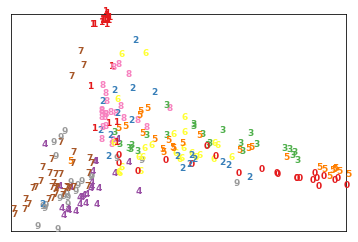

In [13]:
plot_embedding(y_true.numpy(), G.labels.numpy())

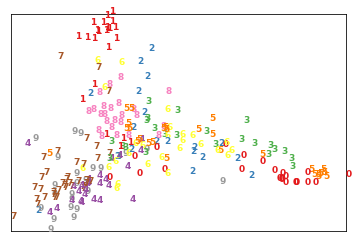

In [14]:
plot_embedding(y_pred.detach().numpy(), G.labels.numpy())

In [15]:
for batch_idx, (inputs, labels) in enumerate(test_loader, start=1):
    if batch_idx > 2: break

    n_samples = inputs.shape[0]
    X_test = inputs.view(n_samples,-1)
    X_test = X_test.numpy()
    G_test = get_graph_block(X_test, labels)

    # Forward pass
    y_pred = net.forward(G_test)

    y_true = G_test.target
    y_true = Variable( torch.FloatTensor(y_true).type(dtypeFloat) , requires_grad=False) 

    # Compute L2 loss
    loss = net.loss(y_pred, y_true)
    loss_test = loss.data[0]

/Users/signapoop/anaconda3/envs/py36/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/Users/signapoop/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


In [16]:
print(loss_test)

tensor(0.2396)


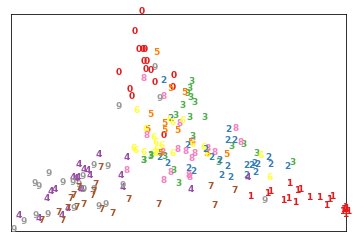

In [17]:
plot_embedding(y_true.numpy(), G_test.labels.numpy())

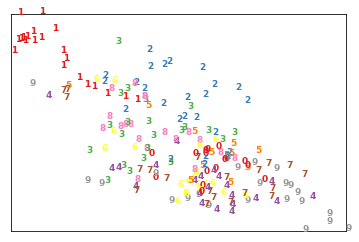

In [18]:
plot_embedding(y_pred.detach().numpy(), G_test.labels.numpy())